# Trabalho Prático 1

Thiago V. de A. Silva (thiagovieiraas [at] gmail [dot] com)



## Importing Modules
On this work, I use:
* 'keras' for building the models,
* 'scikit-learn' to aid me on the evaluation task of the models built,
* and 'pandas' for some data analysis.

Note: The random seed is always 42.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline


np.random.seed(42)

## Loading the Dataset

In [8]:
data = pd.read_csv('data.csv', header=None, sep=',')

Y = data[data.columns[0]]
X = data[data.columns[1:]]

Y = to_categorical(Y)

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

Number of samples: 5000
Number of features: 784


## Plotting the Images

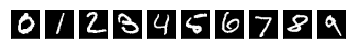

In [9]:
f, pltarr = plt.subplots(1, 10)
for i in range(10):
    img_matrix = data[data[0]==i].iloc[0].values[1:].reshape(28, 28)
    pltarr[i].imshow(img_matrix, cmap='gray', aspect='equal')
    pltarr[i].set_xticks([])
    pltarr[i].set_yticks([])
plt.show()

## Creating Auxiliary Classes

In order to use Keras + scikit_learn it's necessary to define functions (or classes) to build the models, hence that's what I'm going to do now...

Below, there are two classes.
The first one is the *Classifier*. This class was created just to allow me use some callbacks. On the Classifier class I just overwrote the constructor and the get_params function of KerasClassifier. I decided to implement this class mostly to ease the integration between scikit and keras.<br/>

The second class is the *ML_Model*. This class serves to build a new model given two parameters:
<ol>
<li>Learning Rate,</li>
<li>Number of nodes on the hidden layer.</li>
</ol>

On this work, I fixed the first activation function as the *sigmoid* function, and the second as the *softmax*.
I also make sure that no decay, momentum or Nesterov Momentum is used on the model.

The loss function used is the categorial cross entropy, that's equivalent with the function presented by the professor:
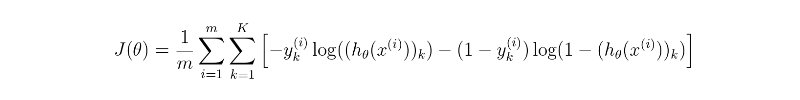

In [10]:
class Classifier(KerasClassifier):
    def __init__(self, build_fn=None, callbacks=[], **sk_params):
        self.build_fn = build_fn
        self.callbacks = callbacks
        self.sk_params = sk_params
        self.sk_params['callbacks'] = callbacks
    
    def get_params(self, deep=True):
        res = copy.deepcopy(self.sk_params)
        res.update({'build_fn': self.build_fn, 'callbacks': self.callbacks})
        return res
    


class ML_Model():
    def __init__(self, plr=0.5, phl=25):
        self.lr_ = plr
        self.hl_ = phl
        
    
    def __call__(self):
        # Building model with keras
        model = Sequential()
        model.add(Dense(self.hl_, input_dim=784, activation='sigmoid'))
        model.add(Dense(10, activation='softmax'))

        sgd = optimizers.SGD(lr=self.lr_, decay=0.0, momentum=0.0, nesterov=False)

        # Compiling the model...
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        return model

## Checking Accuracy

On the cell below, you can find a snippet of code that prints the cross validation score for each possible setting.
On this work, all experiments ran on a 5-fold configuration.

Furthermore, I also use a EarlyStopping callback to indicate the classifier that he can stop whenever the validation loss stop decreasing.

In [5]:
# Setting a early stopping callback...
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')
n_epochs = 100

for b_size in [1, 10, 50, len(Y)]:
    for n_hl in [25, 50, 100]:
        for p_lr in [0.5, 1, 10]:
            kmodel = Classifier(build_fn=ML_Model(p_lr, n_hl), epochs=n_epochs, batch_size=b_size, verbose=0,
                                     validation_split=0.16, callbacks=[early_stopping])

            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            print('Batch size:', b_size, ', Hidden Layers:', n_hl, ', Learning Rate:', p_lr)
            results = cross_val_score(kmodel, X, Y, cv=kfold, n_jobs=-1)
            print(results.mean(), results.std())
            print('')

Batch size: 1 , Hidden Layers: 25 , Learning Rate: 0.5
0.101 0.008074651695274541

Batch size: 1 , Hidden Layers: 25 , Learning Rate: 1
0.1142 0.005114684741017768

Batch size: 1 , Hidden Layers: 25 , Learning Rate: 10
0.1052 0.011651609330903607

Batch size: 1 , Hidden Layers: 50 , Learning Rate: 0.5
0.0962 0.013760813929415654

Batch size: 1 , Hidden Layers: 50 , Learning Rate: 1
0.0984 0.013879481258317975

Batch size: 1 , Hidden Layers: 50 , Learning Rate: 10
0.1072 0.013526270735128732

Batch size: 1 , Hidden Layers: 100 , Learning Rate: 0.5
0.10400000000000001 0.012361229712289954

Batch size: 1 , Hidden Layers: 100 , Learning Rate: 1
0.1072 0.013526270735128732

Batch size: 1 , Hidden Layers: 100 , Learning Rate: 10
0.1072 0.013526270735128732

Batch size: 10 , Hidden Layers: 25 , Learning Rate: 0.5
0.10020000199973582 0.010067770626166822

Batch size: 10 , Hidden Layers: 25 , Learning Rate: 1
0.10080000193417074 0.011923087251008269

Batch size: 10 , Hidden Layers: 25 , Learnin

By the results above, we observe that the SGD and the Mini-Batch were the worse models, in which the best result of them was 23.8%, in comparison with the best GD result, that was 85.7%.

Considering the GD variations, we observe that the best answer correspond to the model that has 100 nodes on the hidden layer, and learning rate of 0.5. This is a consistent result, since the input is highly dimensional (784 values), and learning rate is small enough to reach a point of local minima.

Finally, we are now going to evaluate and analyze the learning curve of each algorithm.
Each column on the graphics matrices represents a Learning Rate: 0.5, 1 and 10 respectively.
The red lines represent the training score, and the green ones represent the validation score.

For each setting, we stored one learning curve per fold. The graphics presented hereafter are the mean of the curves of each fold. Once again, the seed used for randomness is always 42.

## Gradient Descent

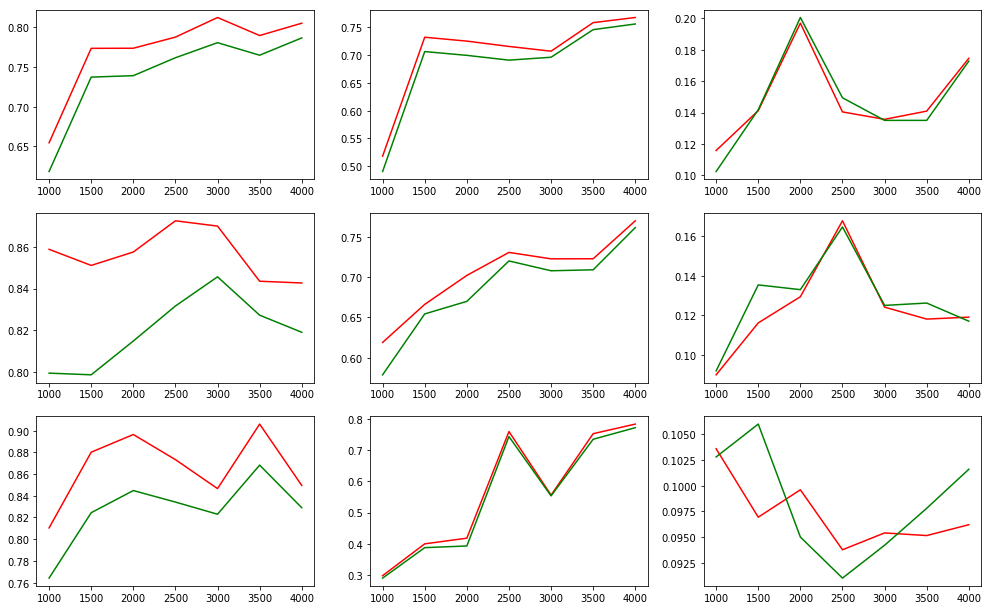

In [23]:
b_size = 5000
f, pltarr = plt.subplots(3, 3)

plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
f.set_figheight(10)
f.set_figwidth(15)

i = -1

for n_hl in [25, 50, 100]:
    i += 1
    j = -1
    for p_lr in [0.5, 1, 10]:
        j += 1
        kmodel = Classifier(build_fn=ML_Model(p_lr, n_hl), epochs=n_epochs, batch_size=b_size, verbose=0,
                                 validation_split=0.16, callbacks=[early_stopping])
        
        train_sizes, train_scores, valid_scores = learning_curve(kmodel, X, Y,
                                                                 train_sizes=np.arange(1000, 4001, 500), cv=5,
                                                                 n_jobs=-1, shuffle=True, random_state=42)
        train_scores = train_scores.mean(axis=1)
        valid_scores = valid_scores.mean(axis=1)
        pltarr[i, j].plot(train_sizes, train_scores, 'r')
        pltarr[i, j].plot(train_sizes, valid_scores, 'g')
plt.show()

## Stochastic Gradient Descent

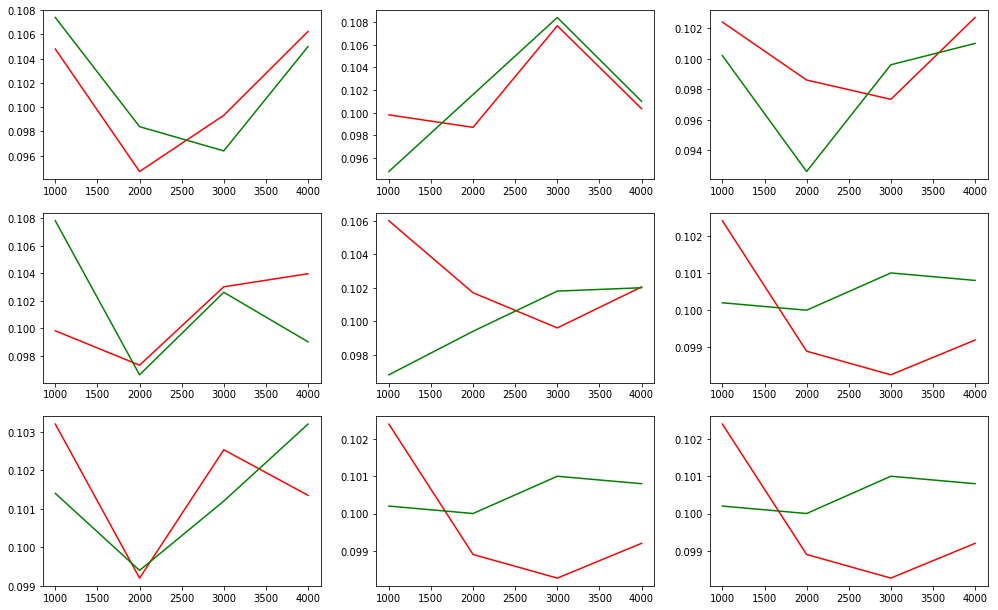

In [24]:
b_size = 1
f, pltarr = plt.subplots(3, 3)

plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
f.set_figheight(10)
f.set_figwidth(15)

i = -1


for n_hl in [25, 50, 100]:
    i += 1
    j = -1
    for p_lr in [0.5, 1, 10]:
        j += 1
        kmodel = Classifier(build_fn=ML_Model(p_lr, n_hl), epochs=n_epochs, batch_size=b_size, verbose=0,
                                 validation_split=0.16, callbacks=[early_stopping])
        
        train_sizes, train_scores, valid_scores = learning_curve(kmodel, X, Y,
                                                                 train_sizes=np.arange(1000, 4001, 1000), cv=5,
                                                                 n_jobs=-1, shuffle=True, random_state=42)
        train_scores = train_scores.mean(axis=1)
        valid_scores = valid_scores.mean(axis=1)
        pltarr[i, j].plot(train_sizes, train_scores, 'r')
        pltarr[i, j].plot(train_sizes, valid_scores, 'g')
plt.show()

## Mini-Batch

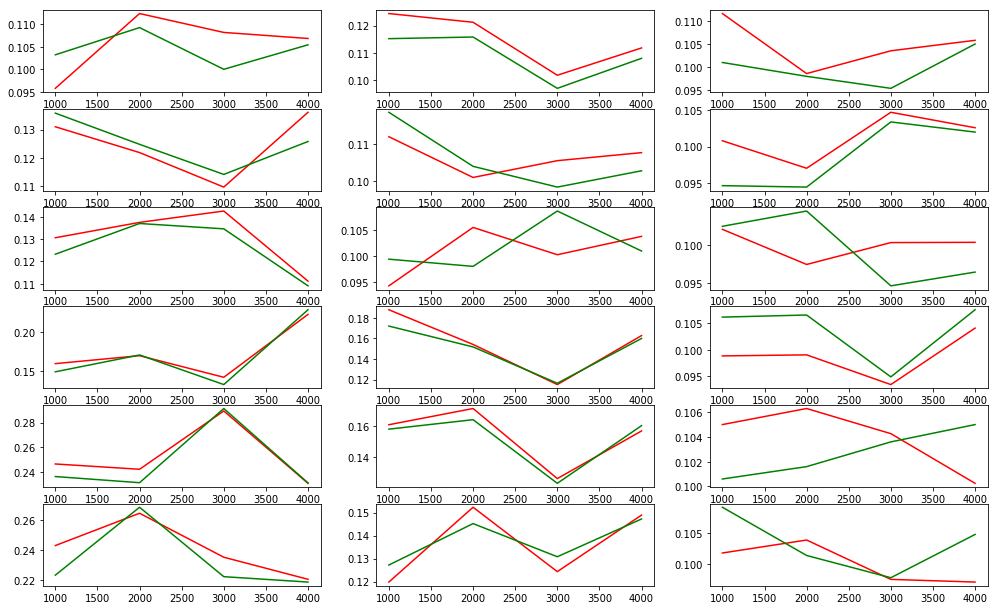

In [26]:
f, pltarr = plt.subplots(6, 3)

plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
f.set_figheight(10)
f.set_figwidth(15)

i = -1

for b_size in [10, 50]:
    for n_hl in [25, 50, 100]:
        i += 1
        j = -1
        for p_lr in [0.5, 1, 10]:
            j += 1
            kmodel = Classifier(build_fn=ML_Model(p_lr, n_hl), epochs=n_epochs, batch_size=b_size, verbose=0,
                                 validation_split=0.16, callbacks=[early_stopping])
        
            train_sizes, train_scores, valid_scores = learning_curve(kmodel, X, Y,
                                                                 train_sizes=np.arange(1000, 4001, 1000), cv=5,
                                                                 n_jobs=-1, shuffle=True, random_state=42)
            train_scores = train_scores.mean(axis=1)
            valid_scores = valid_scores.mean(axis=1)
            pltarr[i, j].plot(train_sizes, train_scores, 'r')
            pltarr[i, j].plot(train_sizes, valid_scores, 'g')
plt.show()

\- Thiago Vieira de Alcantara Silva <br>
2017719891